# Fast low-rank nonnegative tensor factorizations in tensor train format

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as spio
from time import time

from alternating_projections import NTTSVD
from tensor_train import TensorTrain
from info import Info

In [2]:
%%bash
uname -m
sysctl -n machdep.cpu.brand_string
echo -n "CPU(s): " && sysctl -n hw.physicalcpu
echo -n "RAM:    " && sysctl -n hw.memsize | awk '{print $0/1073741824" GB"}'

x86_64
Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
CPU(s): 6
RAM:    16 GB


# 1 Hilbert

In [3]:
sizes = [128, 128, 128]
ranks = [1, 3, 2, 1]

a = np.empty(shape=sizes)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [4]:
# negative elements after TTSVD
full = TensorTrain.GetFullTensor(TensorTrain.TTSVD(a, ranks))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))
print('min element:', full.min())

negative elements (frobenius): 0.09767864271860334
negative elements (density): 6.341934204101562e-05
min element: -0.016309723185813894


## 1.1 NTTSVD

In [5]:
t0 = time()

cores = NTTSVD(a, ranks=ranks, itersNum=250)

print(time() - t0, 's.')
full = TensorTrain.GetFullTensor(cores=cores)
print('relative error:', np.linalg.norm(a - full) / np.linalg.norm(a))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))

41.58865809440613 s.
relative error: 0.07882071085890664
negative elements (frobenius): 8.624020822013567e-16
negative elements (density): 1.9073486328125e-06


## 1.2 Fast NLRT

## 1.2.1 Add the exact minimum element to the tensor

In [15]:
# negative elements after TTSVD
full = TensorTrain.GetFullTensor(TensorTrain.TTSVD(a, ranks))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))
print('min element:', full.min())

negative elements (frobenius): 0.09767864271860334
negative elements (density): 6.341934204101562e-05
min element: -0.016309723185813894


In [16]:
# power method
itersNum1 = 10
itersNum2 = 250

info = Info(label='Fast NLRTA')

# TTSVD
tt = TensorTrain(cores=TensorTrain.TTSVD(a, ranks))
# searching for the minimum element of the tensor
minElement = tt.GetMinElement(algorithm='power', stage1=itersNum1, stage2=itersNum2, debug=True)
# correct the tensor elements
rank1Tensor = TensorTrain.GetRank1Tensor(tt.GetSizes())
rank1Tensor._cores[0] *= -minElement
tt = tt + rank1Tensor
# print result
print()
info.ProcessTensorTrain(originalFullTensor=a, tt=tt)
info.PrintCurrentInfo()

maxElement (true/found): 0.632823587962253 0.6326044627837303
x._ranks [1, 2, 1, 1]
minElement (true/found): -0.016309723185813894 -0.015152407292954528
x._ranks [1, 4, 4, 1]

relative error: 2.0633348472272752
negative elements (frobenius): 0.002633812400856169
negative elements (density): 6.198883056640625e-06


## 1.2.2 Add func(found_minimum) to the tensor

### func(found_minimum) = found_minimum / 50

In [6]:
itersNum = 20
# power method
itersNum1 = 10
itersNum2 = 250

info = Info(label='Fast NLRTA')

t0 = time()

tt = TensorTrain(cores=TensorTrain.TTSVD(a, ranks))
for i in range(itersNum):
    print('=====> iteration:', i)
    minElement = tt.GetMinElement(algorithm='power', stage1=itersNum1, stage2=itersNum2, debug=True)

    rank1Tensor = TensorTrain.GetRank1Tensor(tt.GetSizes())
    rank1Tensor._cores[0] *= -minElement / 50
    tt = tt + rank1Tensor
    
    info.ProcessTensorTrain(originalFullTensor=a, tt=tt)
    print()
    info.PrintCurrentInfo()
    print()

print(time() - t0, 's.')

=====> iteration: 0
maxElement (true/found): 0.632823587962253 0.6326044627837303
x._ranks [1, 2, 1, 1]
minElement (true/found): -0.016309723185813894 -0.015152407292954528
x._ranks [1, 4, 4, 1]

relative error: 0.08618887625091087
negative elements (frobenius): 0.09501231298489164
negative elements (density): 6.198883056640625e-05

=====> iteration: 1
maxElement (true/found): 0.6331266361081122 0.6329065994300468
x._ranks [1, 2, 1, 1]
minElement (true/found): -0.016006675039954805 -0.014849365274161475
x._ranks [1, 4, 4, 1]

relative error: 0.11035541646167628
negative elements (frobenius): 0.0924498727458646
negative elements (density): 5.9604644775390625e-05

=====> iteration: 2
maxElement (true/found): 0.6334236234135954 0.6332026904908068
x._ranks [1, 2, 1, 1]
minElement (true/found): -0.015709687734471574 -0.014552383993112983
x._ranks [1, 4, 4, 1]

relative error: 0.14146013805737745
negative elements (frobenius): 0.08998740783832244
negative elements (density): 5.76972961425781

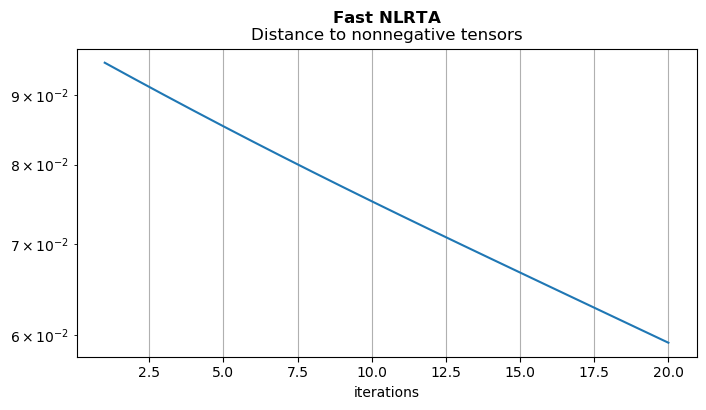

In [7]:
info.PlotNegativeElements()

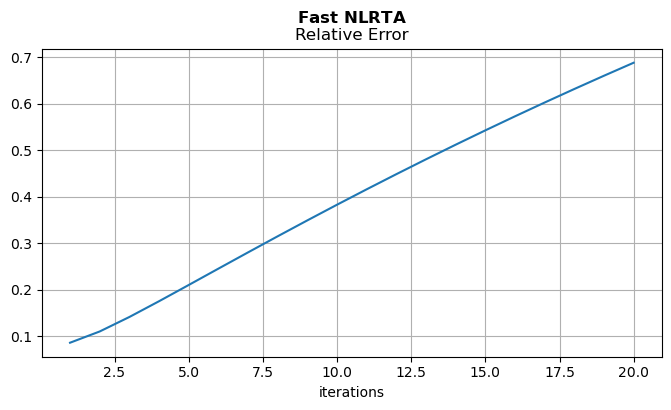

In [8]:
info.PlotErrors()

In [9]:
# time

t0 = time()

tt = TensorTrain(cores=TensorTrain.TTSVD(a, ranks))
for i in range(itersNum):
    minElement = tt.GetMinElement(algorithm='power', stage1=itersNum1, stage2=itersNum2)

    rank1Tensor = TensorTrain.GetRank1Tensor(tt.GetSizes())
    rank1Tensor._cores[0] *= -minElement / 50
    tt = tt + rank1Tensor
    
print(time() - t0, 's.')

127.12432289123535 s.
